# Link del video yt
https://www.youtube.com/watch?v=kCc8FmEb1nY

# Building a GPT

Thesis project by giorgio allena ( giorgio.allena152@edu.unito.it )


## Model

### Variables

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset, load_from_disk
from transformers import DistilBertTokenizer
import transformers

from tqdm import tqdm

from random import randrange
import pandas as pd
import csv


# ------------
# SENTENCE MATRIX
batch_size = 4                 # 16                 # How many independent sequences will we process in parallel ( impact the loss calculation time )
block_size = 250               # 500                 # What is the maximum context length for predictions?

# LOSS
eval_interval = 25        # 100                 # Number iteraction when start to evaluate the loss
eval_iters = 50          # 200                 # Times of testing the LOSS ( impact the loss calculation time )
learning_rate = 1e-3

# DEVICE
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# print(device)

# BLOCKS
n_embd = 64
n_head = 16
n_layer = 16              # 4                  # Number of layers
dropout = 0.2             # 0.0

# ITERACTION
max_iters = 5000          # 10000                # Number of generations
iterator_dataset = 0



# ------------
# SET VARIABLES FOR VALUE REGISTRATION:
savingBasePath = f"save/model_nn_{str(n_layer)}_gen_{str(max_iters)}"
model_name = f'model_nn_{str(n_layer)}_gen_{str(max_iters)}.pt'
csv_file_name = f'loss_nn_{str(n_layer)}_gen_{str(max_iters)}.csv'


df_loss_train = []
df_loss_test = []
df_step = []
fields = ['train_loss', 'loss_test', 'step'] 



# ------------
# LOAD DATASETS AND TOKENIZER:
dataset = load_dataset("llm-wizard/alpaca-gpt4-data", split="train")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')                 # It's a model

torch.manual_seed(1337)
vocab_size = tokenizer.vocab_size


# Loadign pre-training bert tokenizer
encode = lambda s: tokenizer.encode_plus(s, padding="max_length", return_tensors='pt', add_special_tokens=True, max_length=block_size, truncation=True)['input_ids'].flatten().tolist()
decode = lambda s: tokenizer.decode(s)

### RLHF

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]


def get_RLHF_response(question):
    resp = ""
    # TODO: Generate response from AI

    outputs = pipeline(
        messages,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    
    # meta-llama/Meta-Llama-3-8B-Instruct
    
    return resp
        

In [ ]:

outResp = get_RLHF_response("Hello")
print(outResp)


### Model

In [3]:
def get_batch(split, RLHF=False):
    data, dataOut = [], []
    # item = randrange(dataset.num_rows)
    global iterator_dataset

    while(len(data) == 0):
        item = iterator_dataset % dataset.num_rows
        iterator_dataset += 1
        
        data = dataset['instruction'][item] if dataset['input'][item] == "" else dataset['instruction'][item] + ". " + dataset['input'][item]
        dataOut = dataset['output'][item] if RLHF else get_RLHF_response(data)
    
    data_ts = torch.tensor(encode(data), dtype=torch.long)

    dataOut_ts = torch.tensor(encode((data + "" +  dataOut)[:-block_size]), dtype=torch.long)
    
    x = torch.stack([data_ts])
    y = torch.stack([dataOut_ts])
    
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    def sv(self, basePath, number_of_block):
        torch.save(self.net.state_dict(), f"{basePath}/FeedFoward_n{number_of_block}.pt")

    def map(self, basePath, number_of_block, device):
        self.net.load_state_dict(torch.load(f"{basePath}/FeedFoward_n{number_of_block}.pt", map_location=torch.device(device)))


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

    def sv(self, basePath, number_of_block):
        self.ffwd.sv(basePath, number_of_block)

    def map(self, basePath, number_of_block, device):
        self.ffwd.map(basePath, number_of_block, device)
        # torch.load(f"{base_path}/blocks_BigramLanguageModel.pt", map_location=torch.device(device))


# super simple bigram model

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)                        # 64, 28

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

    def sv(self, base_path):
        torch.save(self.blocks.state_dict(), f"{base_path}/blocks_BigramLanguageModel.pt")
               
        for i in range(n_layer):
            self.blocks[i].sv(base_path, i)
        
    def map(self, device, base_path):
        for i in range(n_layer):
            self.blocks[i].map(base_path, i, device)

        self.blocks.load_state_dict(torch.load(f"{base_path}/blocks_BigramLanguageModel.pt", map_location=torch.device(device)))

### Utility functions

In [4]:
import pandas as pd
import os 

#----------------------------
#   CHECK POINT
#----------------------------
def checkpoint_iter(file_iterator_dataset, data=0):
    path_to_check = "/".join(file_iterator_dataset.split("/")[:-1])
    if not os.path.exists(path_to_check):
        os.mkdir(path_to_check) 
        
    f = open(file_iterator_dataset, "w+")
    f.write(str(data))
    f.close()

def checkpoint(model, filename, csv_file_name, fields, rows, file_iterator_dataset, iterator_dataset):
    torch.save(model.state_dict(), filename)

    with open(csv_file_name, 'w') as f:
        write = csv.writer(f)
        
        write.writerow(fields)
        write.writerows(rows)
    
    checkpoint_iter(file_iterator_dataset, iterator_dataset)


def reasume_model(model, filename, device):
    model.load_state_dict(torch.load(filename))
    return model.to(device)
    

def resume(model, filename, device, csv_file_name=None, file_iterator_dataset=None):
    m = reasume_model(model, filename, device)

    df = pd.read_csv(csv_file_name)
    f = open(file_iterator_dataset, "r")
    i_db = f.read()
    
    return m, df.values.tolist(), int(i_db)



#----------------------------
#   SAVE AND LOAD
#----------------------------
def save_model(model, model_path, csv_file_name, fields, rows):
    # Create path
    path_to_check = "/".join(model_path.split("/")[:-1])
    if not os.path.exists(path_to_check):
        os.mkdir(path_to_check) 
    # Save model
    torch.save(model.state_dict(), model_path)
    model.sv(path_to_check)
    # Save loss
    with open(csv_file_name, 'w') as f:
        write = csv.writer(f)
        write.writerow(fields)
        write.writerows(rows)
    
    print("\n SAVED \n")


def reasume_base_data(path_to_save, device, model):
    model.map(device, "/".join(path_to_save.split("/")[:-1]))
    model.load_state_dict(torch.load(path_to_save))
    print("\n LOAD \n")
    return model.to(device)



#----------------------------
#   PRINT
#----------------------------
def run_model(m, device, start_sentence, max_new_tokens=50, commentFlag=False, decoded=False, eliminate_input=True):
    inptVal = encode( start_sentence )
    inptVal = inptVal[:inptVal.index(102)]
    inptVal.append(101)
    inptVal_c = inptVal
    inptVal = torch.as_tensor(inptVal, dtype=torch.long, device=device)
    
    outVal = m.generate(inptVal.view(1, inptVal.size()[0]), max_new_tokens=max_new_tokens)
    outVal = outVal[0].tolist()

    if eliminate_input: outVal = outVal[len(inptVal_c):]
    if decoded: outVal = decode(outVal)
    if commentFlag: print(f" Reponse to str: {start_sentence} => \nOutput predicted:\t  :{outVal} ", end="\n\n")
    
    return outVal

def run_model_zeros(m, device, max_new_tokens=50, commentFlag=False):
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    outVal = decode(m.generate(context, max_new_tokens=50)[0].tolist())
    
    if commentFlag: print(f"\nText: {outVal}")

    return outVal

def plot_loss_graph(df_loss_train, df_loss_test, print_min_val=False):
    df = pd.DataFrame({'train_loss': df_loss_train, 'loss_test': df_loss_test})
    
    if print_min_val:
        print(f"Min val of loss: {df['train_loss'].min() if df['train_loss'].min() < df['loss_test'].min() else df['loss_test'].min()}", end="\n\n")
    
    df.plot(y=['train_loss','loss_test'])
    # df.describe()

    print("\n\n")

## Train

### Train Routine

In [ ]:
def train_routine(m, max_iters, train_type='train', start_epoch = 0):
    rows = [] 
    
    # CHECK_POINT LOADER
    base_path = './cks/check_points_v2'
    if start_epoch>0:
        m, rows, iterator_dataset = resume(m, f"{base_path}/cp{start_epoch}.pth", device, f"{base_path}/loss_orc_{start_epoch}.csv", f"{base_path}/iterator_db.txt")
        start_epoch += 1
        print(rows)

    # TRAINING
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    for epoch in tqdm (range(start_epoch, max_iters), desc="Loading"):
        # every once in a while evaluate the loss on train and val sets
        if epoch % eval_interval == 0 or epoch == max_iters - 1:
            losses = estimate_loss()
            # print(f"\tStep {epoch}: \ttrain loss {losses['train']:.4f}, val loss {losses['val']:.4f}  ")
            df_loss_train.append( round(losses['train'].item(), 4) )
            df_loss_test.append( round(losses['val'].item(), 4) )
            df_step.append( epoch )
    
            rows.append([round(losses['train'].item(), 4), round(losses['val'].item(), 4), epoch])
    
            checkpoint(m, f"{base_path}/cp{epoch}.pth", f"{base_path}/loss_orc_{epoch}.csv", fields, rows, f"{base_path}/iterator_db.txt", iterator_dataset)
            
        # sample a batch of data
        xb, yb = get_batch(train_type, RLHF=train_type=='fine_tuning')
    
        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
        # Update bar
        pass

    return m, fields, rows

### PRE-Training

Loading: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [3:15:10<00:00,  2.34s/it]



 SAVED 




HW: 	story it for for list data write of of on what python is [PAD] product an of to to of for of of data for generate [PAD] concepts list this classify attacker [PAD] language strategy ] looking [PAD]torm depleted benefits [PAD]ish an of calculated organic and audience release



ZI: 	[PAD] we explain an warming compare post condition are spa data soaking, the the the post the the the the [PAD] point used founder [PAD] add'of [PAD] packaging collection brains : of [PAD] addressing the the themar in [PAD] leaks article article the the the, [PAD]





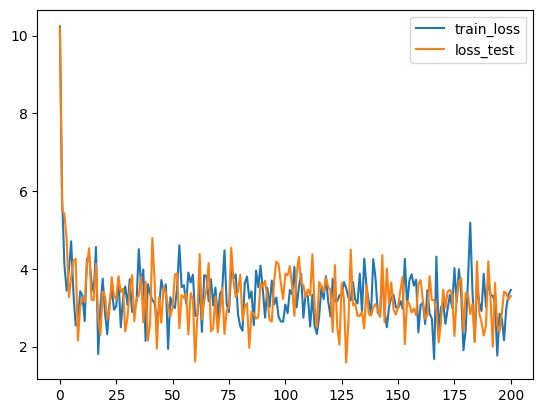

In [5]:
model = BigramLanguageModel()
m = model.to(device)


# Train model
m, fields, rows = train_routine(m, max_iters)


# Save datas
save_model(m, f"./{savingBasePath}/{model_name}", f"./{savingBasePath}/{csv_file_name}", fields, rows)


# Plot outputs
plot_loss_graph(df_loss_train, df_loss_test)
print("HW: \t" + run_model(m , device, "Hello world", decoded=True), end="\n\n\n\n")
print("ZI: \t" + run_model_zeros(m, device), end="\n\n\n\n")

### Fine Tuning (RLHF)

In [ ]:
model = BigramLanguageModel()
m = model.to(device)


# Train model
m, fields, rows = train_routine(m, max_iters, train_type='fine_tuning')


# Save datas
save_model(m, f"./{savingBasePath}/ft_{model_name}", f"./{savingBasePath}/ft_{csv_file_name}", fields, rows)


# Plot outputs
plot_loss_graph(df_loss_train, df_loss_test)
print("HW: \t" + run_model(m , device, "Hello world", decoded=True), end="\n\n\n\n")
print("ZI: \t" + run_model_zeros(m, device), end="\n\n\n\n")

# Tests
This version is from running model

## Load model

In [4]:
# Variable setting
"""
max_iters = 1000
n_layer = 16
"""

savingBasePath = f"save/model_nn_{str(n_layer)}_gen_{str(max_iters)}"
model_name = f'model_nn_{str(n_layer)}_gen_{str(max_iters)}.pt'
csv_file_name = f'loss_nn_{str(n_layer)}_gen_{str(max_iters)}.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Model
model = BigramLanguageModel()
m = reasume_base_data(f"./{savingBasePath}/{model_name}", device, model)


# print(f" Reponse to str: {start_sentence} => \nOutput predicted:\t  :{decode(m.generate(inptVal.view(1, inptVal.size()[0]), max_new_tokens=50)[0].tolist())} ")
# print(f"Input content: tensor([[0]])  => \nOutput predicted:\t  :{decode(m.generate(context, max_new_tokens=50)[0].tolist())")


 LOAD 



## Print

In [6]:
run_model(m, device, "Hello world", decoded=True, eliminate_input=True)

"[CLS] write, of generate the [SEP] [SEP] the,, [PAD]s [PAD] [PAD] arates sd the [PAD] [PAD] [PAD] [PAD].ending generate term required eliminate the his in mathematicald the article [PAD]brush.'[PAD] contribute filled [PAD] greenhouse circumstances [PAD] least name [PAD]"

In [ ]:
# out_St = run_m(m, device, "How are you ?")
out_St = run_m(m, device, "How are you ?")
print(out_St)